In [1]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
import os

In [3]:
os.listdir('data')

['spec', 'super-raw', 'raw']

In [4]:
import numpy as np

In [5]:
x = np.load(os.path.join('data/spec', os.listdir('data/spec')[0])).items()[0][-1]

In [6]:
x

array([[  3.43348246e-07,   5.72193020e-07,   2.34488120e-06, ...,
          2.52556846e-06,   3.05787699e-07,   2.33500656e-06],
       [  3.62610799e-07,   1.07823829e-06,   4.75915650e-06, ...,
          5.52362269e-06,   3.21103645e-07,   2.93054042e-06],
       [  3.94373148e-07,   1.76984692e-06,   7.90500962e-06, ...,
          9.44206776e-06,   3.46200057e-07,   3.69830503e-06],
       ..., 
       [  6.20722968e-06,   4.25677242e-08,   1.43184696e-06, ...,
          1.31346902e-07,   1.18337196e-06,   7.90005106e-07],
       [  5.51061931e-06,   2.25002575e-08,   1.45863013e-06, ...,
          1.42048690e-07,   1.54518521e-06,   8.89907004e-07],
       [  4.78509932e-06,   6.12021651e-09,   1.43607614e-06, ...,
          1.48418850e-07,   1.99556609e-06,   9.80917918e-07]])

In [7]:
x.shape

(184, 512)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
spec_dir = 'data/spec'
spectrograms = [os.path.join(spec_dir, f) for f in os.listdir(spec_dir)]

In [10]:
len(spectrograms)

208952

In [11]:
import random

In [12]:
from sklearn.preprocessing import maxabs_scale 

In [13]:
def load1(f):
    X = np.load(f).items()[0][-1] + 1e-14
    return 14 + np.log10(X).transpose()

def load2(f):
    X = np.load(f).items()[0][-1]
    return maxabs_scale(X).transpose()

In [14]:
samples1 = [load1(random.choice(spectrograms)) for _ in range(100)]
samples2 = [load2(random.choice(spectrograms)) for _ in range(100)]

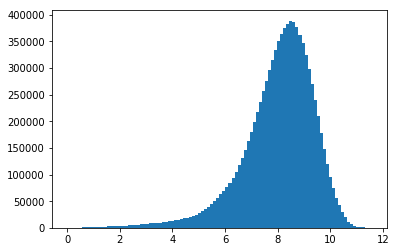

In [15]:
f, ax = plt.subplots()
_ = ax.hist([x for s in samples1
               for x in s.reshape(-1)],
        bins=100)

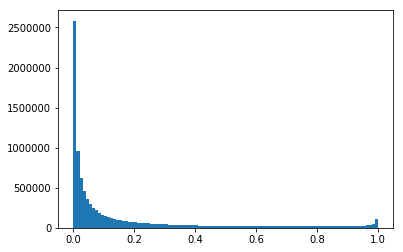

In [16]:
_ = plt.hist([x for s in samples2
                for x in s.reshape(-1)],
             bins=100)

In [17]:
load = load2

data/spec/A Tribe Called Quest-Midnight Marauders-We Can Get Down.mp3 - 89.npz


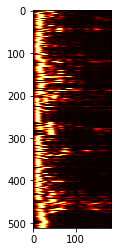

In [18]:
f = random.choice(spectrograms)
print(f)
x = load(f)
plt.imshow(x,  cmap='hot', interpolation='nearest')

# Train

In [41]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPool1D, UpSampling1D, AveragePooling1D
model = Sequential([
    Conv1D(400, 64, padding='same', activation='relu', input_shape=(512, 184)),
    AveragePooling1D(2, padding='same'),
    Conv1D(300, 64, padding='same', activation='relu'),
    AveragePooling1D(2, padding='same'),
    Conv1D(200, 64, padding='same', activation='relu'),
    AveragePooling1D(2, padding='same'),
    Conv1D(150, 32, padding='same', activation='relu'),
    AveragePooling1D(2, padding='same'),
    Conv1D(128, 32, padding='valid', activation='sigmoid', name='encoder'),
    UpSampling1D(8),
    Conv1D(128, 4, padding='same', activation='relu'),
    UpSampling1D(4),
    Conv1D(150, 32, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(200, 64, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(300, 64, padding='same', activation='relu', input_shape=(256, 184)),
    UpSampling1D(2),
    Conv1D(400, 64, padding='same', activation='relu'),
    UpSampling1D(2),
#     Conv1D(184, 1, activation='sigmoid')
    Conv1D(368, 1, activation='relu'),
    Conv1D(184, 1, activation='relu')
])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 512, 400)          4710800   
_________________________________________________________________
average_pooling1d_9 (Average (None, 256, 400)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 256, 300)          7680300   
_________________________________________________________________
average_pooling1d_10 (Averag (None, 128, 300)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 128, 200)          3840200   
_________________________________________________________________
average_pooling1d_11 (Averag (None, 64, 200)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 64, 150)           960150    
__________

In [43]:
# model.compile(optimizer='adadelta', loss='mean_squared_error')

In [19]:
import numpy as np
def data_gen(files, batch_size):
    while True:
        np.random.shuffle(files)
        X = np.zeros((batch_size, 512, 184))
        for i, f in enumerate(files):
            i = i % batch_size
            X[i,:] = load(f)
            if i == batch_size - 1:
                yield X, X
                X = np.zeros((batch_size, 512, 184))

In [45]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, monitor='loss', verbose=1)

In [112]:
epochs = 120
batch_size = 30
steps = len(spectrograms) // batch_size
gen = data_gen(spectrograms, batch_size)
model.fit_generator(gen, steps_per_epoch=steps, epochs=epochs, callbacks=[early_stop])

Epoch 1/120
6965/6965 [==============================] - 3607s 518ms/step - loss: 0.0275
Epoch 2/120
6965/6965 [==============================] - 3607s 518ms/step - loss: 0.0275
Epoch 3/120
6965/6965 [==============================] - 3605s 518ms/step - loss: 0.0274
Epoch 4/120
6965/6965 [==============================] - 3608s 518ms/step - loss: 0.0274
Epoch 5/120
6965/6965 [==============================] - 3619s 520ms/step - loss: 0.0274
Epoch 6/120
6965/6965 [==============================] - 3608s 518ms/step - loss: 0.0273
Epoch 7/120
6965/6965 [==============================] - 3610s 518ms/step - loss: 0.0273
Epoch 8/120
6965/6965 [==============================] - 3609s 518ms/step - loss: 0.0273
Epoch 9/120
6965/6965 [==============================] - 3607s 518ms/step - loss: 0.0273
Epoch 10/120
6965/6965 [==============================] - 3606s 518ms/step - loss: 0.0272
Epoch 11/120
6965/6965 [==============================] - 3608s 518ms/step - loss: 0.0272
Epoch 12/120
6965/6

KeyboardInterrupt: 

data/spec/As I Lay Dying-Shadows Are Security-Through Struggle.mp3 - 199.npz


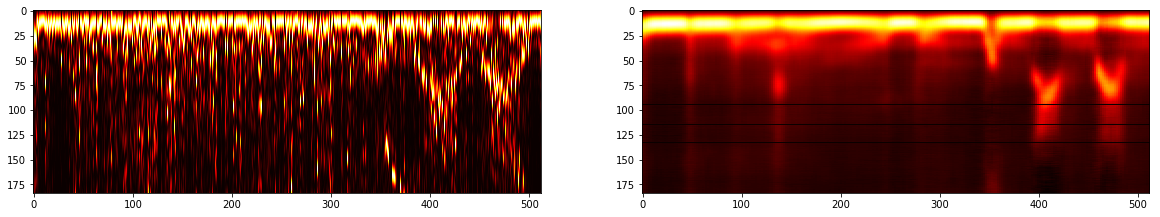

In [25]:
file = random.choice(spectrograms)
print(file)
x = load(file)
x_test = x.reshape(1, 512, 184)
pred = model.predict(x_test)
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(x.transpose(),  cmap='hot', interpolation='nearest')
ax[1].imshow(pred[0].transpose(),  cmap='hot', interpolation='nearest')

In [113]:
# raise Exception
model.save('autoencoder.h5')

# test

In [19]:
try:
    model
except NameError:
    model = keras.models.load_model('autoencoder.h5')

In [20]:
model.get_layer('encoder')

In [21]:
encoder = keras.models.Model(inputs=model.input,
                             outputs=model.get_layer('encoder').output)

In [22]:
encoder.output.shape

TensorShape([Dimension(None), Dimension(1), Dimension(128)])

In [28]:
import itertools

Z = np.array([2**i for i in range(64)], dtype=np.uint64).transpose()

def encode_batch(encoder, files, batch_size):
    # reading all the data at once will likely raise an Exeption.
    # iterate through the files and yield small batches of results
    def gen():
        X = np.zeros((batch_size, 512, 184))
        for i, f in enumerate(files):
            i = i % batch_size
            X[i,:] = load(f)
            if i == batch_size - 1:
                print('predicting')
                p = encoder.predict(X)
                # binarize
                p = np.where(p <= 0.5, 0, 1).astype(np.uint64)
                # have to keep track of two keys since numpy doesn't support 128 bit integers
                code1 = p[:,:,:64] @ Z
                code2 = p[:,:,64:] @ Z
                yield np.array((code1, code2))
                X = np.zeros((batch_size, 512, 184))
    return np.concatenate(list(gen()), axis=1)

In [29]:
len(spectrograms)

208952

In [277]:
# test_samples = random.sample(spectrograms, k=1000)
codes = encode_batch(encoder, spectrograms, 500)

predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting
predicting

In [278]:
codes = codes[:,:,0]  # why?

In [281]:
codes.shape

(2, 208500)

In [427]:
import pandas as pd
df = pd.DataFrame(codes.transpose(), columns=['key1', 'key2'])
df['raw_path'] = spectrograms[:208500]

In [428]:
df[['artist', 'album', 'track', 'seconds']] = df.raw_path.str.split('-', 3, expand=True)

In [429]:
df.head()

,key1,key2,raw_path,artist,album,track,seconds
0,10984857995636140496,7245454145996528644,data/spec/Deep Purple-The Very Best of Deep Pu...,data/spec/Deep Purple,The Very Best of Deep Purple Rhino,Burn.mp3,81.npz
1,9748325218689232953,14123993390522587912,data/spec/Incubus-If Not Now When-If Not Now W...,data/spec/Incubus,If Not Now When,If Not Now When.mp3,134.npz
2,565667948323611675,1157568283545969108,data/spec/Pearl Jam-No Code-Around The Bend.mp...,data/spec/Pearl Jam,No Code,Around The Bend.mp3,203.npz
3,6347122736121320453,1226107231939594246,data/spec/The Bravery-The Bravery-Aoc.mp3 - 38...,data/spec/The Bravery,The Bravery,Aoc.mp3,38.npz
4,2197818195136873480,12683263599620235456,data/spec/Creedence Clearwater Revival-Cosmos ...,data/spec/Creedence Clearwater Revival,Cosmos Factory 2008 40th Anniversary Edition,Lookin Out My Back Door.mp3,41.npz


In [430]:
df.drop('raw_path', axis=1, inplace=True)

In [433]:
df['artist'] = df.artist.str.split('/', expand=True)[2]

In [434]:
df['seconds'] = df.seconds.str.split('.', expand=True)[0]

In [435]:
df.head()

,key1,key2,artist,album,track,seconds
0,10984857995636140496,7245454145996528644,Deep Purple,The Very Best of Deep Purple Rhino,Burn.mp3,81
1,9748325218689232953,14123993390522587912,Incubus,If Not Now When,If Not Now When.mp3,134
2,565667948323611675,1157568283545969108,Pearl Jam,No Code,Around The Bend.mp3,203
3,6347122736121320453,1226107231939594246,The Bravery,The Bravery,Aoc.mp3,38
4,2197818195136873480,12683263599620235456,Creedence Clearwater Revival,Cosmos Factory 2008 40th Anniversary Edition,Lookin Out My Back Door.mp3,41


In [437]:
df.to_csv('codes.csv')

In [286]:
# see,
# https://en.wikipedia.org/wiki/Hamming_distance#Algorithm_example
def hamming(n1, n2):
    # this number is made of each bit in either n1 or n2
    # but not both
    v = n1 ^ n2
    d = 0
    while v != 0:
        # subtracting 1 clears the least bit, a, in v and sets all bits
        # before a which are cleared by the logical &
        # 2^n = sum(2^m for 0 <= m <= n-1)
        d += 1
        v &= v - 1
    return d

In [347]:
from functools import partial
def query(key1, key2, df):
    columns = df.columns
    df_copy = df.copy()
    p1 = partial(hamming, key1)
    p2 = partial(hamming, key2)
    df_copy['diffs'] = df.key1.apply(p1) + df.key2.apply(p2)
    return df_copy[df_copy.diffs <= 15].sort_values('diffs')

In [374]:
from IPython.display import display
key1, key2, song = next(df.sample().itertuples(index=False))
print(key1, key2, song)
res = query(key1, key2, df)
with pd.option_context('display.max_colwidth', -1):
    display(res)

288797724695068672 288307896016568616 The Mars Volta-Frances the Mute-Miranda That Ghost Just Isnt Holy Anymore.mp3 - 134.npz


,key1,key2,song,diffs
147892,288797724695068672,288307896016568616,The Mars Volta-Frances the Mute-Miranda That Ghost Just Isnt Holy Anymore.mp3 - 134.npz,0
131944,567967152865409,141287244169256,Fatboy Slim-Youve Come A Long Way Baby-Praise You.mp3 - 288.npz,14
155235,297237575412744192,2748779732992,mewithoutYou-Ten Stories-Fiji Mermaid.mp3 - 55.npz,14
203176,541065216,9223376439196258336,Radiohead-The Bends-Planet Telex.mp3 - 88.npz,14
153636,1441436654276444160,288230930202492928,David Bowie-Scary Monsters-Its no Game Part 1.mp3 - 11.npz,15


In [381]:
from IPython.display import display
key1, key2, song = next(df.sample().itertuples(index=False))
print(key1, key2, song)
res = query(key1, key2, df)
with pd.option_context('display.max_colwidth', -1):
    display(res)

1122523446220292098 220676487103422660 Bush-The Science Of Things-40 Miles From the Sun.mp3 - 75.npz


,key1,key2,song,diffs
152890,1122523446220292098,220676487103422660,Bush-The Science Of Things-40 Miles From the Sun.mp3 - 75.npz,0
145942,976156320893894658,220676453280260096,Mogwai-Rave Tapes-Master Card.mp3 - 94.npz,12
74627,1128151708803923970,1373597974530400294,The Yardbirds-Ultimate Disc 2-Only the Black Rose.mp3 - 5.npz,13
87223,617028335469461506,148618890916692100,Modest Mouse-The Moon Antarctica-Life Like Weeds.mp3 - 45.npz,13
14286,980660057960218626,17695266316308,Yes-Tales from Topographic Oceans Disc 2-Ritual Nous Sommes du Soleil.mp3 - 1281.npz,14
56523,1121396309362872320,1229482767126126596,TransSiberian Orchestra-Christmas Eve and Other Stories-The First Noel.mp3 - 4.npz,14
115576,618120167695716482,148618891463303236,Minor Bird-Demo-Sunrise6.mp3 - 261.npz,14
189337,975029321475424258,76631633411743764,Metallica-Reload-Bad Seed.mp3 - 240.npz,14
53830,1125671210571661314,76561296754221076,The Yardbirds-Ultimate Disc 1-Still Im Sad.mp3 - 53.npz,15
54107,975064505847513090,76631633411743764,Red Hot Chili Peppers-Californication-Scar Tissue.mp3 - 212.npz,15


In [393]:
from IPython.display import display
key1, key2, song = next(df.sample().itertuples(index=False))
print(key1, key2, song)
res = query(key1, key2, df)
with pd.option_context('display.max_colwidth', -1):
    display(res)

975038115420995730 88100652089396 Beck-Odelay-Minus.mp3 - 126.npz


,key1,key2,song,diffs
28532,975038115420995730,88100652089396,Beck-Odelay-Minus.mp3 - 126.npz,0
146620,975029319327940610,2310434709493023028,Pink Floyd-Ummagumma Studio Album-Grantchester Meadows.mp3 - 367.npz,8
97738,1119144507403829394,4592043876720688,Peter Bjorn John-Writers Block-Objects Of My Affection.mp3 - 270.npz,8
157862,975029319326105730,88099041353780,Metallica-Reload-Where The Wild Things Are.mp3 - 101.npz,9
129372,254470971134738578,4611774119079346288,Beck-Mellow gold-Steal my body home.mp3 - 82.npz,9
27875,1137176498099355802,6922120727920566324,Tool-Lateralus-Disposition.mp3 - 25.npz,10
35642,975046911513985026,1225067061856731188,Modest Mouse-The Moon Antarctica-3rd Planet.mp3 - 221.npz,10
113129,1119144507404091522,4574107959066674,Incubus-Make Yourself-Stellar.mp3 - 193.npz,10
142880,1119162099590135946,4616277718706741300,Phil Keaggy-Lights of Madrid-A Field of Flowers.mp3 - 295.npz,11
141565,1119153307791818890,4616207349962555504,Incubus-When Incubus Attacks Vol 2 -Vitamin Live.mp3 - 315.npz,11


In [397]:
from IPython.display import display
key1, key2, song = next(df.sample().itertuples(index=False))
print(key1, key2, song)
res = query(key1, key2, df)
with pd.option_context('display.max_colwidth', -1):
    display(res)

2147091124496564226 4683816180250574848 As I Lay Dying-The Powerless Rise-Vacancy.mp3 - 107.npz


,key1,key2,song,diffs
205669,2147091124496564226,4683816180250574848,As I Lay Dying-The Powerless Rise-Vacancy.mp3 - 107.npz,0
114413,111464110104969218,91268329927344128,Pearl Jam-Riot Act-Help Help.mp3 - 142.npz,12
103422,128387776168263682,2382405302391668736,Day of Fire-Day of Fire-Through the Fire.mp3 - 222.npz,13
198269,1839720447780978690,72640916127744,Tool-Undertow-Undertow.mp3 - 312.npz,13
66101,686798945321615490,4616261122885943296,The Doors-The Best of the Doors 1985 Disc 2-Riders on the Storm.mp3 - 423.npz,14
102617,975363573010268162,76633763581296768,Mogwai-Rave Tapes-Deesh.mp3 - 166.npz,14
126272,900719925474230272,4505798650626048,The Fall of Troy-Manipulator-Oh The Casino.mp3 - 7.npz,14
115441,1840846347687821314,8724185090,Underoath-Ø Disambiguation-Reversal.mp3 - 56.npz,14
186769,975029321473589250,4611756670723375152,Foster the People-Torches Best Buy Exclusive-Helena Beat.mp3 - 190.npz,15
183065,975029319361495042,4503633988157456,Jimmy Page Robert Plant-Walking Into Clarksdale-House of Love.mp3 - 246.npz,15


In [416]:
from IPython.display import display
key1, key2, song = next(df.sample().itertuples(index=False))
print(key1, key2, song)
res = query(key1, key2, df)
with pd.option_context('display.max_colwidth', -1):
    display(res)

12219744776091804933 12812793717032484946 Modest Mouse-We Were Dead Before The Ship Even Sank-Missed The Boat.mp3 - 212.npz


,key1,key2,song,diffs
77872,12219744776091804933,12812793717032484946,Modest Mouse-We Were Dead Before The Ship Even Sank-Missed The Boat.mp3 - 212.npz,0


# Try cosine similarity

In [446]:
def encode_batch(encoder, files, batch_size):
    # reading all the data at once will likely raise an Exeption.
    # iterate through the files and yield small batches of results
    def gen():
        X = np.zeros((batch_size, 512, 184))
        for i, f in enumerate(files):
            i = i % batch_size
            X[i,:] = load(f)
            if i == batch_size - 1:
                print('predicting')
                yield encoder.predict(X).reshape((batch_size, 128))
                X = np.zeros((batch_size, 512, 184))
    return np.concatenate(list(gen()), axis=0)

In [447]:
codes = encode_batch(encoder, spectrograms[:1000], 500)

predicting
predicting


In [448]:
codes.shape

(1000, 128)

In [449]:
from sklearn.metrics.pairwise import cosine_similarity

In [457]:
sims = cosine_similarity(codes)
sims

array([[ 1.        ,  0.93463838,  0.93561536, ...,  0.95207083,
         0.93441892,  0.93110693],
       [ 0.93463838,  0.99999988,  0.92540884, ...,  0.94186401,
         0.91310763,  0.90346575],
       [ 0.93561536,  0.92540884,  1.00000024, ...,  0.9476133 ,
         0.97747201,  0.92245305],
       ..., 
       [ 0.95207083,  0.94186401,  0.9476133 , ...,  1.00000048,
         0.9418782 ,  0.92908221],
       [ 0.93441892,  0.91310763,  0.97747201, ...,  0.9418782 ,
         0.99999994,  0.92277545],
       [ 0.93110693,  0.90346575,  0.92245305, ...,  0.92908221,
         0.92277545,  0.99999988]], dtype=float32)

In [466]:
i = random.randint(0, len(spectrograms[:1000])-1)
i

625

In [467]:
spectrograms[i]

'data/spec/Creedence Clearwater Revival-Creedence Clearwater Revival 2008 40th Anniversary Edition-Porterville.mp3 - 80.npz'

In [468]:
np.argsort(sims[i])[:5]

array([453, 866, 330, 920, 203])

In [469]:
[spectrograms[j] for j in np.argsort(sims[i])[:5]]

['data/spec/Heart-Heart Greatest Hits Live-Im DownLong Tall Sally.mp3 - 28.npz',
 'data/spec/Louis Armstrong-Hot Fives  Hot Sevens Vol 2 Columbia-Twelfth Street Rag.mp3 - 168.npz',
 'data/spec/The Mars Volta-DeLoused in the Comatorium-Inertiatic ESP.mp3 - 249.npz',
 'data/spec/Gorillaz-The Fall-Aspen Forest.mp3 - 154.npz',
 'data/spec/The Temptations-The Ultimate Collection-Its Growing.mp3 - 0.npz']